# Late Fusion Model by Visit Number

Train and evaluate the late fusion combined model separately for:
- Visit 1 only (first time subjects)
- Visit 2 only (second time subjects)
- Visit 3 only (third time subjects)


In [7]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline


## Load Session Mapping


In [8]:
# Load session mapping to get visit numbers
session_mapping = pd.read_csv('../../data/results/analysis_outputs_POST/session_mapping_POST.csv', 
                              dtype={'mmdd': str, 'hhmm': str, 'user_id': str})

# Create join key
session_mapping['subject_id'] = session_mapping['mmdd'] + '_' + session_mapping['hhmm'] + '_' + session_mapping['user_id']

print(f"Session mapping: {session_mapping.shape}")
print(f"\nVisit number distribution:")
print(session_mapping['visit_number'].value_counts().sort_index())
session_mapping.head()


Session mapping: (99, 10)

Visit number distribution:
visit_number
1.0    51
2.0    34
3.0     8
Name: count, dtype: int64


,filename,date,time,user_id,mmdd,hhmm,team,session,visit_number,subject_id
0,preprocessing_0816_1400_9M4VCHG.json,08/16/2021,14:00,9M4VCHG,0816,1400,Team 12,Session 3,2.0,0816_1400_9M4VCHG
1,preprocessing_0924_1600_9M4VCHG.json,09/24/2021,16:00,9M4VCHG,0924,1600,Team 24,Session 3,3.0,0924_1600_9M4VCHG
2,preprocessing_0825_1000_9M4VCHG.json,08/25/2021,10:00,9M4VCHG,0825,1000,Team 17,Session 2,2.0,0825_1000_9M4VCHG
3,preprocessing_0813_1600_539136F.json,08/13/2021,16:00,539136F,0813,1600,Team 12,Session 2,1.0,0813_1600_539136F
4,preprocessing_0826_1000_539136F.json,08/26/2021,10:00,539136F,0826,1000,Team 17,Session 3,3.0,0826_1000_539136F


## Load Feature Data

Load the preprocessed behavioral features (gaze, pose, audio)


In [9]:
# Load pre-extracted features
with open('../../data/results/features_PRE/extracted_features_PRE.pkl', 'rb') as f:
    feature_data = pickle.load(f)

merged_df = feature_data['merged_df']
physio_cols = feature_data['physio_cols']
behavior_cols = feature_data['behavior_cols']
gaze_cols = feature_data['gaze_cols']

print(f"✓ Loaded {len(merged_df)} trials from {merged_df['subject_id'].nunique()} subjects")
print(f"\nFeature counts:")
print(f"  Physiology: {len(physio_cols)} features")
print(f"  Behavior: {len(behavior_cols)} features")
print(f"  Gaze: {len(gaze_cols)} features")
print(f"\nOutcome distribution:")
print(merged_df['outcome'].value_counts())
merged_df.head()


✓ Loaded 12511 trials from 97 subjects

Feature counts:
  Physiology: 13 features
  Behavior: 7 features
  Gaze: 20 features

Outcome distribution:
outcome
1    8238
0    4273
Name: count, dtype: int64


,subject_id,trial_id,pupil_mean_pre,pupil_std_pre,pupil_slope_pre,time_to_peak_pre,pupil_cv_pre,pupil_velocity_mean_pre,pupil_max_dilation_rate_pre,pupil_max_constriction_rate_pre,...,gaze_velocity_std,gaze_velocity_max,gaze_acceleration_mean,gaze_acceleration_std,fixation_ratio,saccade_ratio,saccade_count,gaze_dispersion_x,gaze_dispersion_y,gaze_path_length
0,0806_1000_539136F,4_0806_1000_539136F,0.964343,0.385919,-0.606697,0.416583,0.400189,0.015452,0.038500,0.046608,...,14.832241,151.113087,402.826146,2255.555213,0.982047,0.010772,5,0.992564,1.217398,10.413850
1,0806_1000_539136F,5_0806_1000_539136F,0.565622,0.235529,-0.275488,0.499900,0.416406,0.021373,0.033413,0.070067,...,12.976377,151.906203,123.007226,1040.010223,0.986957,0.008696,1,1.670589,1.897844,7.029506
2,0806_1000_539136F,8_0806_1000_539136F,0.459276,0.162388,0.050625,1.249750,0.353575,0.013204,0.036714,0.028571,...,3.000848,32.825149,79.670709,488.156167,0.995283,0.000000,0,0.242891,0.298672,1.951801
3,0806_1000_539136F,9_0806_1000_539136F,0.210854,0.453631,0.530171,1.716324,2.151394,0.027890,0.120311,0.082170,...,16.694540,152.816573,501.677348,2798.929771,0.982533,0.013100,6,0.977366,0.962262,9.468620
4,0806_1000_539136F,12_0806_1000_539136F,0.471785,0.231209,0.245656,1.083117,0.490072,0.016514,0.047882,0.031266,...,3.875644,35.961829,107.686584,585.656280,0.994565,0.000000,0,0.279835,0.543686,2.267213


## Prepare Data by Visit Number


In [10]:
# Add visit numbers to merged_df by joining with session_mapping
merged_df = merged_df.merge(
    session_mapping[['subject_id', 'visit_number']],
    on='subject_id',
    how='left'
)

print(f"Merged dataframe: {merged_df.shape}")
print(f"\nTrials with visit_number: {merged_df['visit_number'].notna().sum()} / {len(merged_df)}")
print(f"\nVisit number distribution:")
print(merged_df['visit_number'].value_counts().sort_index())

# Split data by visit
df_visit1 = merged_df[merged_df['visit_number'] == 1.0].copy()
df_visit2 = merged_df[merged_df['visit_number'] == 2.0].copy()
df_visit3 = merged_df[merged_df['visit_number'] == 3.0].copy()

print(f"\nVisit 1: {len(df_visit1)} trials from {df_visit1['subject_id'].nunique()} subjects")
print(f"Visit 2: {len(df_visit2)} trials from {df_visit2['subject_id'].nunique()} subjects")
print(f"Visit 3: {len(df_visit3)} trials from {df_visit3['subject_id'].nunique()} subjects")


Merged dataframe: (12511, 44)

Trials with visit_number: 11751 / 12511

Visit number distribution:
visit_number
1.0    6317
2.0    4495
3.0     939
Name: count, dtype: int64

Visit 1: 6317 trials from 49 subjects
Visit 2: 4495 trials from 34 subjects
Visit 3: 939 trials from 8 subjects


## Feature Extraction Function


In [11]:
from sklearn.impute import SimpleImputer

def extract_features_and_labels(df, physio_cols, behavior_cols, gaze_cols):
    """
    Extract combined features (physio + behavior + gaze) and labels from dataframe.
    """
    # Impute missing values
    X_physio = SimpleImputer(strategy='mean').fit_transform(df[physio_cols])
    X_behavior = SimpleImputer(strategy='mean').fit_transform(df[behavior_cols])
    X_gaze = SimpleImputer(strategy='mean').fit_transform(df[gaze_cols])
    
    # Combine features (late fusion at feature level)
    X_combined = np.concatenate([X_physio, X_behavior, X_gaze], axis=1)
    
    y = df['outcome'].values
    subjects = df['subject_id'].values
    
    print(f"Features shape: {X_combined.shape}")
    print(f"  Physio: {X_physio.shape[1]}, Behavior: {X_behavior.shape[1]}, Gaze: {X_gaze.shape[1]}")
    print(f"Labels shape: {y.shape}")
    print(f"Unique subjects: {len(np.unique(subjects))}")
    print(f"Label distribution: {np.bincount(y)}")
    
    return X_combined, y, subjects


## LOSO Cross-Validation Function


In [12]:
def run_loso_cv(X, y, subjects, random_state=42):
    """
    Run Leave-One-Subject-Out cross-validation with balanced class weights.
    """
    logo = LeaveOneGroupOut()
    
    all_y_true = []
    all_y_pred = []
    subject_accuracies = []
    
    for train_idx, test_idx in logo.split(X, y, subjects):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train model with balanced class weights
        clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', 
                                     random_state=random_state, n_jobs=-1)
        clf.fit(X_train, y_train)
        
        # Predict
        y_pred = clf.predict(X_test)
        
        # Store results
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        
        # Subject-level accuracy
        subject_acc = accuracy_score(y_test, y_pred)
        subject_accuracies.append(subject_acc)
    
    # Overall metrics
    overall_acc = accuracy_score(all_y_true, all_y_pred)
    overall_f1 = f1_score(all_y_true, all_y_pred, average='weighted')
    
    results = {
        'accuracy': overall_acc,
        'f1_score': overall_f1,
        'subject_accuracies': subject_accuracies,
        'y_true': all_y_true,
        'y_pred': all_y_pred
    }
    
    return results


## Run Model for Visit 1


In [13]:
print("="*70)
print("VISIT 1: First Time Subjects")
print("="*70)

X1, y1, subjects1 = extract_features_and_labels(df_visit1, physio_cols, behavior_cols, gaze_cols)
results_v1 = run_loso_cv(X1, y1, subjects1)

print(f"\nOverall Accuracy: {results_v1['accuracy']:.4f}")
print(f"Overall F1 Score: {results_v1['f1_score']:.4f}")
print(f"Mean Subject Accuracy: {np.mean(results_v1['subject_accuracies']):.4f} ± {np.std(results_v1['subject_accuracies']):.4f}")
print(f"\nClassification Report:")
print(classification_report(results_v1['y_true'], results_v1['y_pred']))


VISIT 1: First Time Subjects
Features shape: (6317, 40)
  Physio: 13, Behavior: 7, Gaze: 20
Labels shape: (6317,)
Unique subjects: 49
Label distribution: [2419 3898]

Overall Accuracy: 0.6742
Overall F1 Score: 0.6545
Mean Subject Accuracy: 0.6754 ± 0.0984

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.39      0.48      2419
           1       0.69      0.85      0.76      3898

    accuracy                           0.67      6317
   macro avg       0.65      0.62      0.62      6317
weighted avg       0.66      0.67      0.65      6317



## Run Model for Visit 2


In [14]:
print("="*70)
print("VISIT 2: Second Time Subjects")
print("="*70)

X2, y2, subjects2 = extract_features_and_labels(df_visit2, physio_cols, behavior_cols, gaze_cols)
results_v2 = run_loso_cv(X2, y2, subjects2)

print(f"\nOverall Accuracy: {results_v2['accuracy']:.4f}")
print(f"Overall F1 Score: {results_v2['f1_score']:.4f}")
print(f"Mean Subject Accuracy: {np.mean(results_v2['subject_accuracies']):.4f} ± {np.std(results_v2['subject_accuracies']):.4f}")
print(f"\nClassification Report:")
print(classification_report(results_v2['y_true'], results_v2['y_pred']))


VISIT 2: Second Time Subjects
Features shape: (4495, 40)
  Physio: 13, Behavior: 7, Gaze: 20
Labels shape: (4495,)
Unique subjects: 34
Label distribution: [1332 3163]

Overall Accuracy: 0.7026
Overall F1 Score: 0.6532
Mean Subject Accuracy: 0.6943 ± 0.1778

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.19      0.27      1332
           1       0.73      0.92      0.81      3163

    accuracy                           0.70      4495
   macro avg       0.61      0.55      0.54      4495
weighted avg       0.66      0.70      0.65      4495



## Run Model for Visit 3


In [15]:
print("="*70)
print("VISIT 3: Third Time Subjects")
print("="*70)

X3, y3, subjects3 = extract_features_and_labels(df_visit3, physio_cols, behavior_cols, gaze_cols)
results_v3 = run_loso_cv(X3, y3, subjects3)

print(f"\nOverall Accuracy: {results_v3['accuracy']:.4f}")
print(f"Overall F1 Score: {results_v3['f1_score']:.4f}")
print(f"Mean Subject Accuracy: {np.mean(results_v3['subject_accuracies']):.4f} ± {np.std(results_v3['subject_accuracies']):.4f}")
print(f"\nClassification Report:")
print(classification_report(results_v3['y_true'], results_v3['y_pred']))


VISIT 3: Third Time Subjects
Features shape: (939, 40)
  Physio: 13, Behavior: 7, Gaze: 20
Labels shape: (939,)
Unique subjects: 8
Label distribution: [360 579]

Overall Accuracy: 0.5548
Overall F1 Score: 0.5376
Mean Subject Accuracy: 0.5773 ± 0.1515

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.29      0.33       360
           1       0.62      0.72      0.67       579

    accuracy                           0.55       939
   macro avg       0.50      0.50      0.50       939
weighted avg       0.53      0.55      0.54       939



## Compare Results Across Visits


In [16]:
# Summary comparison
comparison_df = pd.DataFrame({
    'Visit': [1, 2, 3],
    'N_subjects': [df_visit1['subject_id'].nunique(), df_visit2['subject_id'].nunique(), df_visit3['subject_id'].nunique()],
    'N_trials': [len(df_visit1), len(df_visit2), len(df_visit3)],
    'Accuracy': [results_v1['accuracy'], results_v2['accuracy'], results_v3['accuracy']],
    'F1_Score': [results_v1['f1_score'], results_v2['f1_score'], results_v3['f1_score']],
    'Mean_Subject_Acc': [
        np.mean(results_v1['subject_accuracies']),
        np.mean(results_v2['subject_accuracies']),
        np.mean(results_v3['subject_accuracies'])
    ],
    'Std_Subject_Acc': [
        np.std(results_v1['subject_accuracies']),
        np.std(results_v2['subject_accuracies']),
        np.std(results_v3['subject_accuracies'])
    ]
})

print("\n" + "="*70)
print("COMPARISON ACROSS VISITS")
print("="*70)
print(comparison_df.to_string(index=False))



COMPARISON ACROSS VISITS
 Visit  N_subjects  N_trials  Accuracy  F1_Score  Mean_Subject_Acc  Std_Subject_Acc
     1          49      6317  0.674212  0.654451          0.675353         0.098416
     2          34      4495  0.702558  0.653195          0.694306         0.177848
     3           8       939  0.554846  0.537642          0.577269         0.151526


## Visualization: Accuracy Comparison


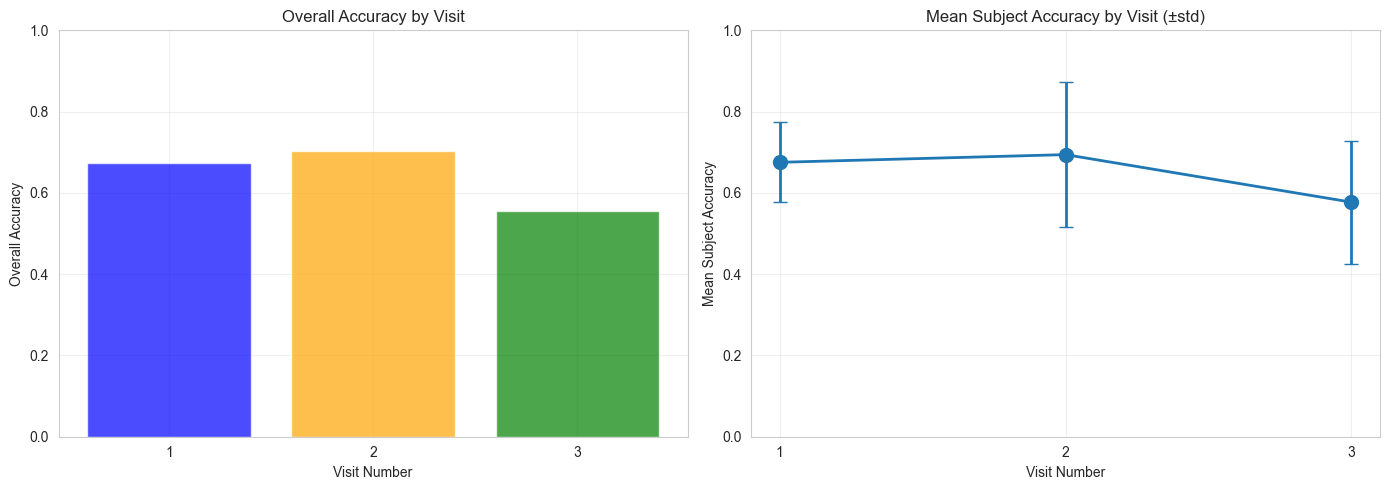

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall accuracy by visit
axes[0].bar([1, 2, 3], comparison_df['Accuracy'], 
           color=['blue', 'orange', 'green'], alpha=0.7)
axes[0].set_xlabel('Visit Number')
axes[0].set_ylabel('Overall Accuracy')
axes[0].set_title('Overall Accuracy by Visit')
axes[0].set_ylim(0, 1)
axes[0].set_xticks([1, 2, 3])
axes[0].grid(True, alpha=0.3)

# Mean subject accuracy with error bars
axes[1].errorbar([1, 2, 3], comparison_df['Mean_Subject_Acc'], 
                yerr=comparison_df['Std_Subject_Acc'],
                marker='o', capsize=5, linewidth=2, markersize=10)
axes[1].set_xlabel('Visit Number')
axes[1].set_ylabel('Mean Subject Accuracy')
axes[1].set_title('Mean Subject Accuracy by Visit (±std)')
axes[1].set_ylim(0, 1)
axes[1].set_xticks([1, 2, 3])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Distribution of Subject Accuracies


/var/folders/rf/b27xv8554s30yymsz5rpvw340000gn/T/ipykernel_22970/3183477695.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data_for_box, labels=['Visit 1', 'Visit 2', 'Visit 3'],


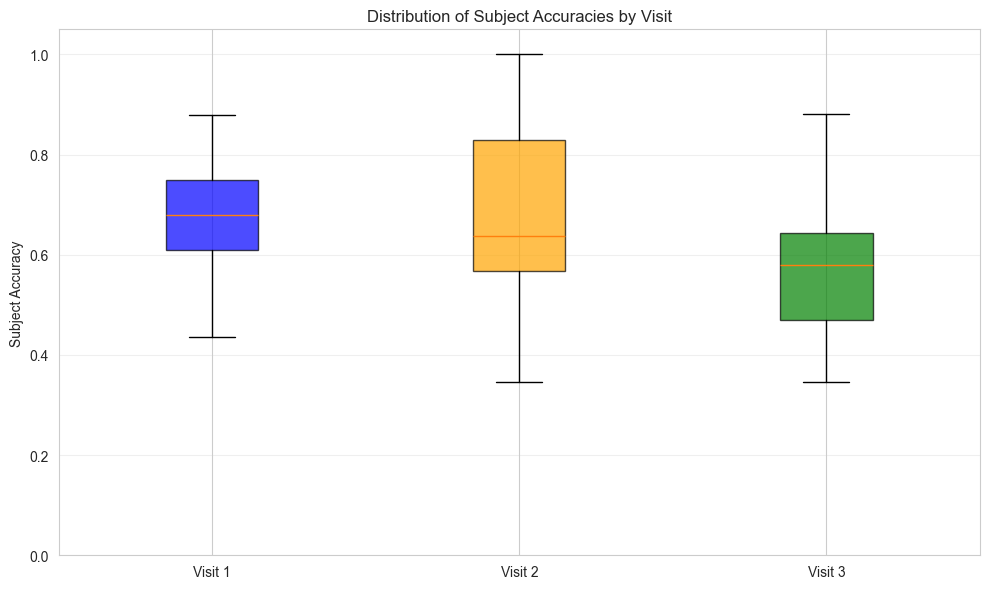

In [18]:
# Box plot of subject accuracies
plt.figure(figsize=(10, 6))

data_for_box = [
    results_v1['subject_accuracies'],
    results_v2['subject_accuracies'],
    results_v3['subject_accuracies']
]

bp = plt.boxplot(data_for_box, labels=['Visit 1', 'Visit 2', 'Visit 3'],
                patch_artist=True)

# Color the boxes
colors = ['blue', 'orange', 'green']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.ylabel('Subject Accuracy')
plt.title('Distribution of Subject Accuracies by Visit')
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


## Save Results


In [19]:
# Save comparison results
comparison_df.to_csv('../../data/results/analysis_outputs_PRE/late_fusion_by_visit_comparison_PRE.csv', index=False)
print("✓ Saved comparison to: ../data/results/late_fusion_by_visit_comparison.csv")

# Save detailed results
results_dict = {
    'visit_1': results_v1,
    'visit_2': results_v2,
    'visit_3': results_v3
}

with open('../../data/results/model_outputs_PRE/late_fusion_by_visit_results_PRE.pkl', 'wb') as f:
    pickle.dump(results_dict, f)
print("✓ Saved detailed results to: ../data/results/late_fusion_by_visit_results.pkl")


✓ Saved comparison to: ../data/results/late_fusion_by_visit_comparison.csv
✓ Saved detailed results to: ../data/results/late_fusion_by_visit_results.pkl
